# An Analysis of Four Different Formulations of Chalk on Grip Strength

Ethan Basingr and Jerry H. Yu

## Introduction

Climbing Chalk is commonly used to enhance grip strength in sports like rock climbing or powelifting. Most commercial brands of climbing chalk are made with Magnesium Carbonate (MgCO3). However, Magnesium carbonate has a wide variety of crystal structures that can affect its ability to absorb water and other fluids. My friend Ethan spent month designing a new way to crystallize MgCO3 to hopefull make suprior chalk to commercial brands. This report analyzes an experiment he conducted with a third friend analyze and chalk to other brands. 

## Methods

The experiment was conducted as an unbalanced block design. Testing constraints prevented the easy swapping between chalks during a single test, so chalks were testred sequentially across days, resulting in confounding. While such bias is impossible to correct completley for the final analysis, I did try two approaches to correct it. I decided to use mixed models to evaluate the data. 

In [1]:
# Set Up Python Enviroment
import math
import numpy as np
import pandas as pd
import plotly.express as px
import os
import git
import rpy2
%load_ext rpy2.ipython
import statsmodels
import statsmodels.formula.api as smf
repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)
print(os.getcwd())

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


c:\Users\Public\Documents\Personal_Projects\Ethan_Chalk_Project


In [2]:
%%R
# Set Up R Enviroment in Python
library(tidyverse)
library(lmtest)
library(here)
library(lme4) 
library(MASS)
library(MuMIn)
library(caret)
library(clubSandwich)
library(emmeans)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: 'zoo'


R[write to console]: The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


R[write to console]: here() starts at C:/Users/Public/Documents/Personal_Projects/Ethan_Chalk_Project

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: 'Matrix'


R[write to console]: The following objects are masked from 'package:tidyr':

    expand, pack, unpack


R[write to console]: 
Attaching package: 'MASS'


R[write to console]: The following object is masked from 'package:dplyr':

    select


R[write to console]: Loading required package: lattice

R[write to console]: 
Attaching package: 'caret'


R[write to console]: The following object is masked from 'package:purrr':

    lift


R[write to console]: Registered S3 method overwritten by 'clubSandwich':
  method    from    
  bread.mlm sandwich

R[write to console]: Welcome to

# Data

The original data was not formatted in the way of a long table, so I used excel to clean the data. Multiple explanatory variables were encoded in color or order of the tables, so they needed to be made explicit. I used a series of formulas for that. Thus, I created long formats of the `Chalk_Results.xlsx` and `Randomized tests.xlsx` (`Chalk_Long.xlsm` and `Metadata.slsx`) and merged and created labels for them in python. 

Variables are:
- **Code:** a number from 1-24. In excel, this column's color is indicative of date, and its value is also indicative of control (or chalk) and treatment. Code + bChalk form the key for merging metadata with chalk_long. 
- **bChalk:** a number from 1-4 (1=FL. 2=Metolius, 3=Magdust, 4=Ethan's Chalk), not directly indicative of whether chalk was used. Code + bChalk form the key for merging metadata with chalk_long.
- **Pinch_Order:** Order in which test was conducted, for each attempt (code number), the test was performed three times sequentially. Pinch_Order + bChalk + Code forms the primary key. 
- **Pinch:** The weight at which the board was pinched. 
- **Pull:** The weight just before the hand slipped. **Our dependent variable**. 
- **Chalk:** The actual chalk used, 0 is added for control. 
- **Person:** The person conducting the test, one intermediate and one advanced climber. 
- **Day:** The day when the test was conducted. Dates were, 10/30/2024,10/31/2024,11/4/2024,11/6/2024,11/8/2024,11/10/2024, and 11/14/2024. Last two were apparently "noticeably slippery". 
- **Day_Order:** The order in which the tests were conducted in the day. This was randomized. 

# Wrangling

The wrangling section is below. Mostly easy to clean, but some variables needed to be converted into factors. 

In [3]:
# Read in and Merge Data and Metadata
Chalk_Long = pd.read_excel('data/Raw/Chalk_Long.xlsm', sheet_name=1, header=0)
metadata = pd.read_excel('data/Raw/Metadata.xlsx', sheet_name=1, header=0)
Chalk = pd.merge(metadata, Chalk_Long, on=["Code","bChalk"], how='left')
Chalk.to_csv('data/Processed/Chalk.csv', index=False)
# Convert Labels into factor variables for further analysis
Chalk["Chalk"] = Chalk["Chalk"].astype("category")
Chalk["Chalk"] = Chalk["Chalk"].cat.rename_categories(["None", "FL", "Metolius", "Magdust", "Ethan"])
Chalk["Person"] = Chalk["Person"].astype("category")
Chalk["Pinch_Order"] = Chalk["Pinch_Order"].rank(method='dense')
Chalk["Day_Chalk"] = Chalk["Day"].astype("str") + "_" + Chalk["Chalk"].astype("str")

In [4]:
# Now let us check that our wrangling worked as expected
Chalk.info()
Chalk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Code         576 non-null    int64         
 1   bChalk       576 non-null    int64         
 2   Day_Order    576 non-null    int64         
 3   Day          576 non-null    datetime64[ns]
 4   Pinch        576 non-null    float64       
 5   Pull         576 non-null    float64       
 6   Pinch_Order  576 non-null    float64       
 7   Chalk        576 non-null    category      
 8   Person       576 non-null    category      
 9   Day_Chalk    576 non-null    object        
dtypes: category(2), datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 37.6+ KB


,Code,bChalk,Day_Order,Day,Pinch,Pull,Pinch_Order,Chalk,Person,Day_Chalk
0,16,1,1,2024-10-30,4.202,34.6,1.0,None,1,2024-10-30_None
1,16,1,1,2024-10-30,4.117,31.9,2.0,None,1,2024-10-30_None
2,16,1,1,2024-10-30,4.154,31.9,3.0,None,1,2024-10-30_None
3,34,1,2,2024-10-30,4.088,41.1,1.0,FL,2,2024-10-30_FL
4,34,1,2,2024-10-30,4.088,44.5,2.0,FL,2,2024-10-30_FL


# EDA

Next Graphs to Visualize Key Variables

- First I will check the distributions of the numeric variables. 

In [5]:
# Graph Pinch
pinchist = px.histogram(Chalk,x="Pinch",
                        title = "Distribution of Pinch Strength",
                        nbins = 20)
pinchist.update_layout(
    title = {
        "text":"Distribution of Pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
pinchist.show()
# weird shape, good coverage, no noticable outliers

Notes:
- at lower weights, obviously had more control so more centered around 1 lb, 2lb etc. However the distirbution is pretty uniform

In [6]:
# Graph Pull
pullhist = px.histogram(Chalk,x="Pull",
                        title = "Distribution of Pull Strength")
pullhist.update_layout(
    title = {
        "text":"Distribution of Pull Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
pullhist.show()
#right tail, might need normalization

- Very significant right skew. This is a sign of nonnormality. 

In [7]:
# Now Graph Relation Between Pinch and Pull
pinchpull = px.scatter(Chalk, x = "Pinch", y = "Pull",title = "Kilograms Pulled by pinch Strength")
pinchpull.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
pinchpull.show()

#nice and Linear, but maybe not homoscedastic

- This shows a mostly linear relationship by very homoscedastic data. 

Now we will split this relationship by some of the categorical variables to evaluate impact. 

In [8]:
# Type of Chalk
byChalk = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Chalk", title = "Kilograms Pulled by pinch Strength")
byChalk.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byChalk.show()

# Very Nice Separation

byDate = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Day", title = "Kilograms Pulled by pinch Strength")
byDate.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byDate.show()
# There are still clear patterns in the date, but very confounded with chalk. 

- The patterns found in both date and chalk are not a good sign. This indicates two seemingly significant effects that are nonetheless highly confounded. 

In [14]:
# Person
byPerson = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Person", title = "Kilograms Pulled by pinch Strength")
byPerson.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byPerson.show()

# Clear Difference by person, as expected

In [15]:
# Test Pinch Order
byOrder = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Pinch_Order", title = "Kilograms Pulled by pinch Order")
byOrder.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Order<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byOrder.show()

# Very random, quite nice

# Test Day Order
byDay = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Day_Order", title = "Kilograms Pulled by Day_Order")
byDay.update_layout(
    title = {
        "text":"Kilograms Pulled by Day_Order<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byDay.show()
%R -i Chalk

# Generally Also Pretty Random

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning:

Error while trying to convert the column "Person". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.



### Graph Summary
- From our EDA we have generally shown that there appears to be good separation from chalk and person, and negligible for day order and pinch order.
- However, we cannot avoid confonding of chalk and day, and both seem to have potentially saignificant effects. 
- The data is also somewhat group unbalanced, with control being overrepresented. Linearity looks fine, but not homoscedasticity or normality.

Now we will test assumptions needed for Linear Mixed Models. I will increase power using chalk instead of bChalk initially for testing. So instead of each individual chalk, we are testing whether using chalk at all is significant. This results in control and treatment groups of roughly equal size and removes confounding from type of chalk by ignoring it. 

In [33]:
%%R -o resid -o predict
Chalk$Person = as.factor(Chalk$Person)
# Now we will test assumptions needed for Linear Mixed Models
# First Fit a Full Model of All Relevant Variables and a model without Date to Test Significance of Date
fullmodel = lmer(Pull~Pinch*Chalk + (1 | Day) + (1|Person),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail) 
nodate = lm(Pull~Pinch*Chalk*Person, 
            data = Chalk)
print(AIC(fullmodel, nodate))
# Very Very Siginificant Effect on Fit
resid = summary(fullmodel)$residuals
predict = predict(fullmodel)

          df      AIC
fullmodel 13 3544.087
nodate    21 3523.575


- Clearly Date is very significant to model fit, so we will try to keep it. 

Now Test Heteroscedasticity by plotting residuals.

In [31]:
testrelresid = px.scatter(x = predict,
                          y = resid,
                          title = "Residuals",
                          labels = {"x": "Predicted Values", "y": "Residuals"})
testrelresid.show()
# Very Heteroscedastic

- Very heteroscedastic. Now Test Normality


	Shapiro-Wilk normality test

data:  residuals(fullmodel)
W = 0.98712, p-value = 5.752e-05



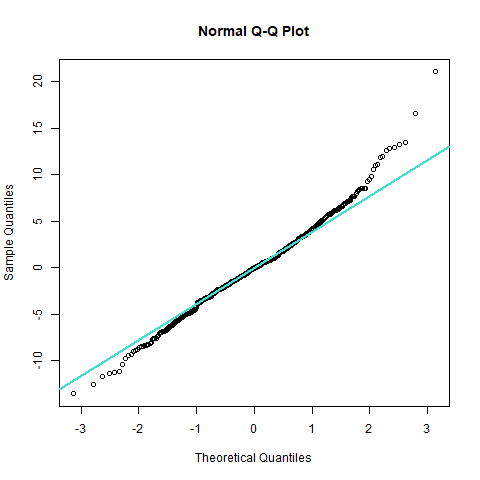

In [18]:
%%R
qqnorm(residuals(fullmodel))
qqline(residuals(fullmodel),col="turquoise",lwd=2)
# Towards the Top seems nonormal
shapiro.test(residuals(fullmodel))
# Also Nonnormal

# Data Analysis Plan

### Summary
- Use linear mixed models to model the effect of chalk, person, and pinch strength on pull strength. 
- Model Day and as a random effect.
- Perform pairwise contrasts between types of chalk
- To address heteroscedasticity, I tried a variety of different transforms. The one that worked the best was a log transform of the dependent variable (Pull). Even this was not enough, so I also ended up using robust (sandwhich) estimators. 
- To address confounding, I used three approaches. 

### Confounding

The next sections will contain three approaches to deal with confounding.

1. Ignore: Fit model with random effects as if there is no confounding. 
2. Controlmodel: Use the covariance matrix from only the no chalk group (our control) to model the effects of day. This assumes the effects of day are the same across all types of chalk and control.
3. Give Up: Fit model on the interaction term of BChalk and Date

### Model Fitting

I used a 5 Fold Cross Validation Method with best subsets model to select the top 3 models per fold on AIC and BIC. Generally, the simpler model that appeared across all five folds was selected. 


## Approach Number One: Ignore Confounding

In [27]:
%%R -o validation_df 
# Set Seed
set.seed(123)

# Split chalk for 5 fold cross validation to check stability of models
chalkfolds = createFolds(y=Chalk$Pull,
                         k=5,
                         list=TRUE,
                         returnTrain = TRUE)

# Create the Testing Function
Validation = function(train_indices){
  # Subset the Data
  train = Chalk[train_indices,]
  test = Chalk[-train_indices,]
  
  # Get the Full Model
  fullmodel = lmer(log(Pull)~Pinch*bChalk + (1|Day) + (1|Person),
                    data = train,
                    REML = FALSE,
                    na.action=na.fail) 
  
  # Best Subsets with Dredge
  table = dredge(fullmodel)
  tableBIC = dredge(fullmodel,rank=BIC)
  
  # Select the Top 3 Models From AIC and BIC
  table
  tableBIC
  
  top3AIC = get.models(table,1:3)
  top3BIC = get.models(table,1:3)
  
  # Keep the Common Models
  top = c(top3AIC,top3BIC)
  top = top[unique(names(top))]
  
  testLL = vector("list",length(top))
  for(i in 1:length(top)){
    testLL[i] = logLik(top[[i]],newdata=test)
  }
  names(testLL) = names(top)
  
  return(c(testLL,top))
}

# Run the Function
crossvalresults = lapply(chalkfolds,Validation)
cvalnames = lapply(crossvalresults,function(x) x[1:3])
cvalformulas = lapply(crossvalresults,function(x) x[4:length(x)])

# Makre a DF with the LLs
validation_df <- bind_rows(
  purrr::imap(cvalnames, ~ tibble(
    crossvalresults = .y,
    model = names(.x),
    value = unlist(.x)
  ))
)



R[write to console]: Fixed term is "(Intercept)"

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: Fixed term is "(Intercept)"

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: Fixed term is "(Intercept)"

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: Fixed term is "(Intercept)"

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: Fixed term is "(Intercept)"

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: Fixed term is "(Intercept)"

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: Fixed term is "(Intercept)"

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]:

In [28]:
%%R
# Show that Name is consistent across folds
print(c(names(cvalformulas[[1]][1]),formula(cvalformulas[[1]][[1]])))
print(c(names(cvalformulas[[2]][2]),formula(cvalformulas[[2]][[2]])))
print(c(names(cvalformulas[[3]][1]),formula(cvalformulas[[3]][[1]])))
print(c(names(cvalformulas[[4]][1]),formula(cvalformulas[[4]][[1]])))
print(c(names(cvalformulas[[5]][2]),formula(cvalformulas[[5]][[2]])))
# Look at Table of LLs
print(validation_df)
# Very Little Differences 

# Look at Formulas
print(formula(cvalformulas[[1]][[1]]))
print(formula(cvalformulas[[1]][[2]]))
print(formula(cvalformulas[[1]][[3]]))

[[1]]
[1] "4"

[[2]]
log(Pull) ~ bChalk + Pinch + (1 | Day) + (1 | Person)
<environment: 0x000001cb992d3b58>

[[1]]
[1] "8"

[[2]]
log(Pull) ~ bChalk + Pinch + (1 | Day) + (1 | Person) + bChalk:Pinch
<environment: 0x000001cba27c9238>

[[1]]
[1] "4"

[[2]]
log(Pull) ~ bChalk + Pinch + (1 | Day) + (1 | Person)
<environment: 0x000001cb99d85770>

[[1]]
[1] "8"

[[2]]
log(Pull) ~ bChalk + Pinch + (1 | Day) + (1 | Person) + bChalk:Pinch
<environment: 0x000001cb96873ec0>

[[1]]
[1] "8"

[[2]]
log(Pull) ~ bChalk + Pinch + (1 | Day) + (1 | Person) + bChalk:Pinch
<environment: 0x000001cb9ae6b830>

# A tibble: 15 x 3
   crossvalresults model value
   <chr>           <chr> <dbl>
 1 Fold1           4     -172.
 2 Fold1           8     -171.
 3 Fold1           3     -176.
 4 Fold2           4     -169.
 5 Fold2           8     -169.
 6 Fold2           3     -173.
 7 Fold3           4     -158.
 8 Fold3           8     -157.
 9 Fold3           3     -160.
10 Fold4           8     -155.
11 Fold4      

Thus our top models are 48, 64, and 128. I will choose model 48 (log(Pull) ~ bChalk + Person + Pinch + (1 | Day) + bChalk:Person + Person:Pinch) for simplcity. 

In [235]:
%%R
# Fit a full model with the best formula
finalmodel1 = lmer(log(Pull)~Pinch*bChalk*Person + bChalk:Person + Person:Pinch + (1|Day),
                   data = Chalk,
                   REML = TRUE,
                   na.action=na.fail)
summary(finalmodel1)

Linear mixed model fit by REML ['lmerMod']
Formula: log(Pull) ~ Pinch * bChalk * Person + bChalk:Person + Person:Pinch +  
    (1 | Day)


   Data: Chalk

REML criterion at convergence: 420.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4610 -0.6768  0.0644  0.7591  2.4809 

Random effects:
 Groups   Name        Variance Std.Dev.
 Day      (Intercept) 0.001394 0.03734 
 Residual             0.111605 0.33407 
Number of obs: 576, groups:  Day, 7

Fixed effects:
                      Estimate Std. Error t value
(Intercept)           2.013967   0.117073  17.203
Pinch                 0.376335   0.028121  13.383
bChalk               -0.008150   0.043275  -0.188
Person2              -0.007891   0.161613  -0.049
Pinch:bChalk         -0.003698   0.010336  -0.358
Pinch:Person2        -0.001171   0.039799  -0.029
bChalk:Person2       -0.171369   0.059276  -2.891
Pinch:bChalk:Person2  0.023307   0.014633   1.593

Correlation of Fixed Effects:
            (Intr) Pinch  bChalk Persn2 Pnch:C Pnc:P2 bCh:P2
Pinch       -0.873                                          
bChalk      -0.908  0.792                           

In [226]:
%%R

print(c(names(cvalformulas[[1]][1]),formula(cvalformulas[[1]][[1]])))
print(c(names(cvalformulas[[2]][2]),formula(cvalformulas[[2]][[2]])))
print(c(names(cvalformulas[[3]][1]),formula(cvalformulas[[3]][[1]])))
print(c(names(cvalformulas[[4]][1]),formula(cvalformulas[[4]][[1]])))
print(c(names(cvalformulas[[5]][2]),formula(cvalformulas[[5]][[2]])))

[[1]]
[1] "48"

[[2]]
log(Pull) ~ bChalk + Person + Pinch + (1 | Day) + bChalk:Person + 
    Person:Pinch
<environment: 0x000002704c38e8a8>

[[1]]
[1] "48"

[[2]]
log(Pull) ~ bChalk + Person + Pinch + (1 | Day) + bChalk:Person + 
    Person:Pinch
<environment: 0x000002706284c2a0>

[[1]]
[1] "48"

[[2]]
log(Pull) ~ bChalk + Person + Pinch + (1 | Day) + bChalk:Person + 
    Person:Pinch
<environment: 0x0000027053a8bd30>

[[1]]
[1] "48"

[[2]]
log(Pull) ~ bChalk + Person + Pinch + (1 | Day) + bChalk:Person + 
    Person:Pinch
<environment: 0x000002705b8c2668>

[[1]]
[1] "48"

[[2]]
log(Pull) ~ bChalk + Person + Pinch + (1 | Day) + bChalk:Person + 
    Person:Pinch
<environment: 0x00000270613f9a28>



# Conclusions
- 